# Cell Assignment Model from FUCCI-Matched Single-Cell Paper

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest
    A. UMAPs 
    B. Rand Index score
7. **Cell phase assignment model from FUCCI-matched single cell paper (GSE146773)**
8. Differential Expression analysis.
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment


This script is dedicated to the functional phenotypic validation of the Isoform-Specific single-cell Perturb-Seq data. Specifically, it implements a machine learning pipeline to assign cell cycle phases (G1, S, and G2/M) to every individual cell in the screen to determine how specific promoter knockdowns disrupt cellular proliferation.

Training a Robust Cell Cycle Classifier
Instead of relying on generic markers, the authors trained a specialized model to accurately identify cell states.


Reference Dataset: The model uses a public dataset (GSE146773) where cells were physically sorted by FUCCI (Fluorescent Ubiquitination-based Cell Cycle Indicator) and then sequenced, providing a "ground truth" for the cell cycle phase.


K-Nearest Neighbors (KNN): The code trains a KNN classifier on this reference data using highly variable cell cycle-regulated genes.


Performance Validation: The notebook uses ROC Curves to verify accuracy, achieving a score of 0.84, which significantly outperforms the standard cell cycle scoring methods typically used in single-cell analysis.

In [ ]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin

#form a location
loc="alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA
import hdbscan
import statsmodels.stats.weightstats as ws

# Taken from: 
# Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.
# My experiment deals with two KDs- one of the MP, one of the AP using two guides. Positve controls include GINS1 ect. This is a combnatorial KD double for the same gene. No treatments were used

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

import os

os.environ['OMP_NUM_THREADS'] = '1'
import scipy.stats as stats 
###guide_num

# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2])
palette2 = sns.color_palette([color1, color2, color3, color4,color5,color6 ,color7])

# Create the color palette
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])

#change palette to 3d82c4 36a047
palette=sns.color_palette(["#f3766e", "#7094cd"])
cellcycle_palette=sns.color_palette(["#36a047", "#7671b3","#d76127"])

print("Scanpy", sc.__version__)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Scanpy 1.10.3


In [ ]:

#onvert the ensembl_id tohgnc_gene_id
#get the ensembl_gene_id for each hgnc_symbol 
annot = sc.queries.biomart_annotations(
            "hsapiens",
            ["ensembl_gene_id","hgnc_symbol","ensembl_peptide_id" ],
        ).set_index("hgnc_symbol").dropna()




In [ ]:
adata = ad.read_h5ad(loc+"files/adata_normalised.h5ad")
#subset for successful knockdowns 
adata=adata[(adata.obs["successfulKD"]=="True" )|(adata.obs["guide_id"]=="non-targeting_Control") ]
adata.X=adata.layers["counts"] #make sure log1p
sc.pp.log1p(adata)
#filter adata with highly variable genes 
# adata=adata[:,adata.var["highly_variable"]==True]
adata.var=adata.var.merge(annot[["ensembl_gene_id"]].drop_duplicates(), left_index=True, right_index=True, how="left").groupby(["gene_id"]).head(n=1) #find ensembl_id

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:406: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
#provide the counts and labels for trianing data
loc="alt-prom-crispr-fiveprime/"
counts_training_data=loc+"files/cellcycle_assignment/GSE146773_Counts.csv.gz"
labels_training_data=loc+"files/cellcycle_assignment/180911_*csv"
human_genes_loc=loc+"files/cellcycle_assignment/human_periodic.tsv"

In [ ]:
#form adata dataframe  
GSE146773_adata = ad.read_csv(counts_training_data)
#filter the genes get the 
sc.pp.filter_genes(GSE146773_adata, min_cells=10)
sc.pp.log1p(GSE146773_adata)
#convert the adata.
GSE146773_adata.var=GSE146773_adata.var.merge(annot[["ensembl_gene_id"]].drop_duplicates(), left_index=True, right_on="ensembl_gene_id", how="left")
#remove na in GSE146773_adata.var
#make var_names a string
GSE146773_adata.var_names=GSE146773_adata.var_names.astype(str)
GSE146773_adata=GSE146773_adata[:,~GSE146773_adata.var.index.isna()]
GSE146773_adata.var_names_make_unique()
###scanpy
cell_cycle_genes = [x.strip() for x in open(loc+'files/cellcycle_assignment/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes=pd.DataFrame(cell_cycle_genes)
print(cell_cycle_genes.shape )
cell_cycle_genes=cell_cycle_genes.merge(annot, right_index=True, left_on=0, how="left").groupby([0]).head(n=1)
print(cell_cycle_genes.shape )
cell_cycle_genes.columns=["hgnc_symbol","ensembl_gene_id","protein_id"]
s_genes = [x for x in cell_cycle_genes["hgnc_symbol"][:43] if x in GSE146773_adata.var_names]
g2m_genes = [x for x in cell_cycle_genes["hgnc_symbol"][43:] if x in GSE146773_adata.var_names]
print(len(s_genes) , len(g2m_genes))


(97, 1)
(97, 3)
42 52


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:

sc.tl.score_genes_cell_cycle(GSE146773_adata, s_genes=s_genes, g2m_genes=g2m_genes)
GSE146773_adata.obs["G1_score"]=GSE146773_adata.obs["G2M_score"]/GSE146773_adata.obs["S_score"]

#read in the seurat input assignment
GSE146773_counts_labels=label_from(labels_training_data)
GSE146773_counts_labels=GSE146773_adata.obs.merge(GSE146773_counts_labels,left_index=True, right_on="cell_name")
#fill na as S
GSE146773_counts_labels["Population"]=np.where(GSE146773_counts_labels["Population"]=="S-ph","S",GSE146773_counts_labels["Population"])

s_genes = [x for x in cell_cycle_genes["hgnc_symbol"][:43] if x in adata.var_names]
g2m_genes = [x for x in cell_cycle_genes["hgnc_symbol"][43:] if x in adata.var_names]
#add s_genes and s_genes_reg tgethe
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:406: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
... storing 'Population' as categorical
... storing 'Sample' as categorical


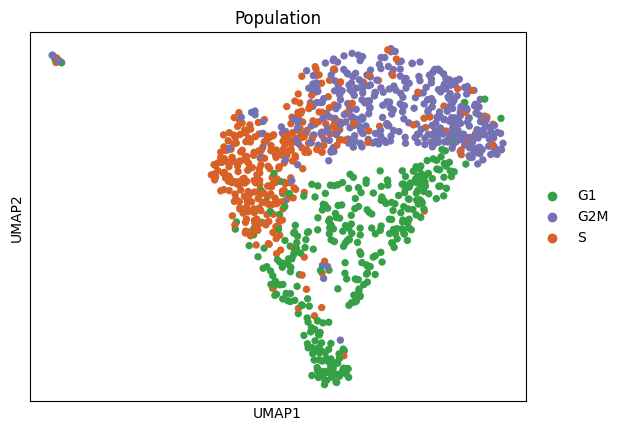

Population
G2M    387
G1     346
S      334
Name: count, dtype: int64
Best score: 0.8361272530286614
Best number of neighbors: 5
Best parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [ ]:
(knn, X_train, X_test, y_train, y_test,gene_subset,scaler)=train_model(counts_training_data,labels_training_data,human_genes_loc, adata, genes_regev=cell_cycle_genes,genelist="regev")

93


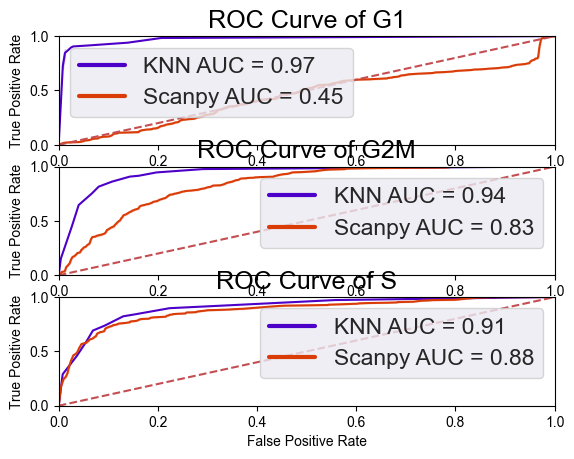

In [ ]:
#replace na in list with "S"
# y_test=[x if x in ["G1","G2M","S"] else "S" for x in y_test] 
#change S in GSE146773_counts_labels["Population"] to S-ph
GSE146773_counts_labels["Population"]=np.where(GSE146773_counts_labels["Population"]=="S-ph","S",GSE146773_counts_labels["Population"])
print(len((gene_subset).drop_duplicates()))
cell_cycle_scores=compare_seurat(X_test,y_test,GSE146773_counts_labels ,knn, color1=color1,color2=color2)

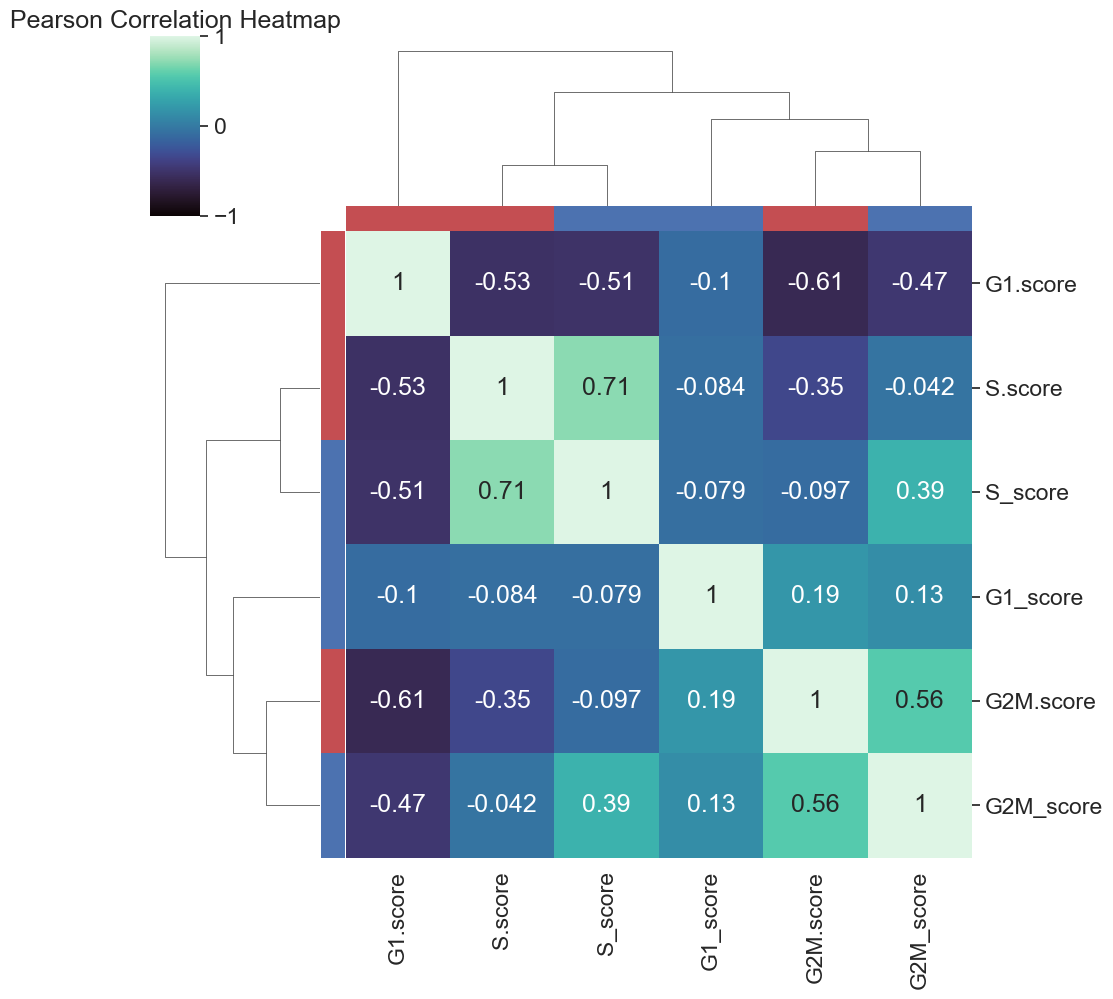

In [ ]:
cell_cycle_scores=cell_cycle_scores.merge(GSE146773_counts_labels, left_index=True, right_on="cell_name")
colours=array(["r","r","r","b","b","b"])
d= cell_cycle_scores[['G1.score', 'G2M.score', 'S.score','S_score', 'G2M_score','G1_score']]
sns.clustermap(d.corr(), cmap="mako",
               vmin = -1, vmax = 1, row_colors=colours, col_colors=colours, figsize=(10,10), annot=True)
plt.title("Pearson Correlation Heatmap")
plt.savefig(loc+"figures/heatmap.pdf")
plt.show()

In [ ]:
adata.var_names=adata.var["ensembl_gene_id"].astype(str)
adata.var_names_make_unique()
cellcycle_dataframe=adata[:,gene_subset]

sc.pp.pca(cellcycle_dataframe, n_comps=30)
sc.pp.neighbors(cellcycle_dataframe, n_pcs=30)
sc.tl.umap(cellcycle_dataframe)
cellcycle_dataframe=pd.DataFrame(data=cellcycle_dataframe.obsm["X_umap"],index=cellcycle_dataframe.obs_names)
Z_test=pd.DataFrame(cellcycle_dataframe)
Z_pred=knn.predict(Z_test)
#subset the new dataframe
cell_cycle_scores=pd.DataFrame(knn.predict_proba(Z_test), columns=["G1.score","G2M.score","S.score"])
#set index to be S phase if score is > 0.1
cell_cycle_scores["cell_barcode"]=Z_test.index
cell_cycle_scores["predicted_score"]=Z_pred
cell_cycle_scores["predicted_score"].value_counts()

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


predicted_score
G1     11260
S       7455
G2M     4510
Name: count, dtype: int64

In [ ]:
#merge adata.obs and cell_cycle_scores on cellbarcode
adata.obs=adata.obs.merge(cell_cycle_scores, left_index=True, right_on="cell_barcode", how="left").set_index("cell_barcode")
# adata.obs=pd.concat([adata.obs.reset_index(drop=True), cell_cycle_scores], axis=1)

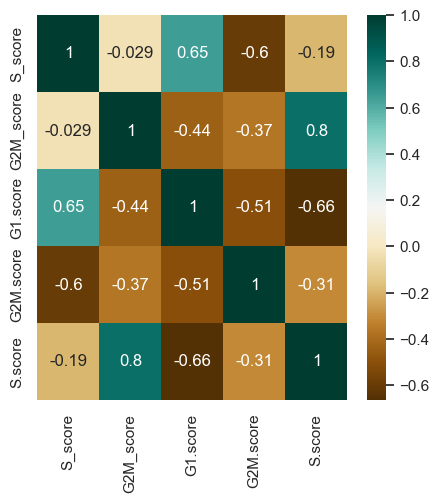

In [ ]:
#change the shape of sns
sns.set(rc={'figure.figsize':(5,5)})
d= adata.obs[['S_score', 'G2M_score', 'G1.score','G2M.score', 'S.score']]
# Compute the correlation matrix
# mask = np.triu(np.ones_like(d.corr(), dtype=bool))
heatmap = sns.heatmap(d.corr(), annot=True, cmap='BrBG')
plt.show()

In [ ]:
# Calculate G1 score as the ratio of G2M score to S score
adata.obs["G1_score"] = adata.obs["G2M_score"] / adata.obs["S_score"]

# Define columns for phase assignment
columns_phase_scanpy = ['guide_assignment', 'promoter_type', 'perturbation', 'guide_id', 'S_score', 'G2M_score', 'G1_score', 'phase']

# Create G1 score and define columns for phase assignment
columns_phase_assignment = ['guide_assignment', 'successfulKD', 'promoter_type', 'perturbation', 'guide_id', 'S.score', 'G2M.score', 'G1.score', 'predicted_score']
#filter for :successfulKD
phase_assignment = adata.obs[columns_phase_assignment].drop_duplicates()
# Save phase assignment to CSV
phase_assignment.to_csv(loc + 'files/phase_assignment.csv')

# Define columns for calculating the number of cells in each phase and guide assignment
columns_phase_scanpy_sub = ['guide_assignment', 'promoter_type', 'phase']
columns_phase_assignment_sub = ['guide_assignment', 'promoter_type', 'predicted_score']

# Group by guide assignment and promoter type, then count the number of occurrences
phase_assignment = phase_assignment.groupby(columns_phase_assignment_sub, observed=False).size().reset_index()
phase_assignment.columns = ['guide_assignment', 'promoter_type', 'phase', 'count']

# Extract target gene, guide number, and promoter type from guide assignment
phase_assignment["target_gene"] = phase_assignment["guide_assignment"].str.split("_").str.get(0)
phase_assignment.loc[:, "guide_num"] = phase_assignment.loc[:, "guide_assignment"].str.split("_").str.get(-1)
phase_assignment["promoter_type_2"] = phase_assignment["guide_assignment"].str.split("_").str.get(1)

# Subselect the non-targeting cells
phase_assignment = phase_assignment[phase_assignment["promoter_type"] == phase_assignment["promoter_type_2"]]

# Calculate the change in percentage of cells in each phase relative to non-targeting control
# Calculate the count percentage per guide assignment
phase_assignment_phase = phase_assignment[['guide_assignment', 'phase', 'count']].groupby(['guide_assignment']).agg({'count': 'sum'})
phase_assignment_phase = phase_assignment_phase[phase_assignment_phase["count"] > 2]

# Merge the total count with the phase assignment data
phase_assignment_phase = phase_assignment_phase.merge(phase_assignment, left_index=True, right_on="guide_assignment", how="left", suffixes=('_total', ''))

# Calculate the percentage of cells in each phase
phase_assignment_phase["percentage"] = phase_assignment_phase["count"] / phase_assignment_phase["count_total"] * 100
phase_assignment_phase["guide_num"] = phase_assignment_phase["guide_num"].astype(int)

/var/folders/r_/bqnt2f_d6919cz7v1yzx2ykc0000gn/T/ipykernel_12504/1767973535.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  phase_assignment_phase = phase_assignment[['guide_assignment', 'phase', 'count']].groupby(['guide_assignment']).agg({'count': 'sum'})


In [ ]:
non_targeting=phase_assignment_phase[phase_assignment_phase["promoter_type"]=="Control"]
print(non_targeting["target_gene"].unique())
ttest_list=[]
for phase in ["G2M","S","G1"]:
    non_targeting_phase=non_targeting[non_targeting["phase"]==phase]
    for gene in phase_assignment_phase["target_gene"].unique():
        for promoter in ["MP","AP"]:
            #ztest for each phase
            #subset the data for the gene and phase
            gene_phase=phase_assignment_phase[(phase_assignment_phase["target_gene"]==gene) & (phase_assignment_phase["promoter_type"]==promoter) & (phase_assignment_phase["phase"]==phase)]
            #test them with 
            # print(gene_phase.head())
            if gene_phase.shape[0]==2:
                p1_perc=gene_phase["percentage"][gene_phase["guide_num"]==1].values[0]
                p2_perc=gene_phase["percentage"][gene_phase["guide_num"]==2].values[0]
                ss_score=num_sim(p1_perc,p2_perc)
                ttest=ws.ttest_ind(gene_phase["count"],non_targeting_phase["count"],alternative="two-sided", usevar="unequal")
                ttest_list.append([gene,phase,promoter,ttest[1],ttest[0],ss_score])

ttest_df=pd.DataFrame(ttest_list, columns=["target_gene","phase","promoter_type","pvalue","tstat","corr"])
ttest_df=ttest_df.sort_values(by="pvalue")
ttest_df["significant"]=multi.fdrcorrection(ttest_df["pvalue"],method="p")[0]
ttest_df["adj_pvalue"]=multi.fdrcorrection(ttest_df["pvalue"],method="p")[1]
print(ttest_df["significant"].value_counts())
non_targeting.to_csv(loc+"files/non_targeting.csv")

['non-targeting']
significant
False    230
True      31
Name: count, dtype: int64


Identifying Promoter-Specific Proliferation Defects
The authors apply this trained model to their perturbed cell populations to see which alternative promoters control the "molecular switch" of cell division.




Statistical Enrichment: Using a two-sided z-test, the code identifies promoters that cause a significant shift in the distribution of cell phases compared to non-targeting controls.



Major Finding: The analysis reveals that 34.38% of alternative promoters significantly alter the cell cycle

In [ ]:
#merge ttest_df with phase_assignment_phase
phase_assignment_phase=phase_assignment_phase.merge(ttest_df)
phase_assignment_phase["gene"]=phase_assignment_phase["target_gene"]
phase_assignment_phase.to_csv(loc+'files/phase_assignment_phase.csv')
phase_assignment_phase=phase_assignment_phase.merge(adata_full.obs[["gene","successfulKD"]].drop_duplicates().reset_index(drop=True), left_on="target_gene", right_on="gene", how="left")

successfulKJD=phase_assignment_phase[["target_gene","promoter_type","significant"]][phase_assignment_phase["successfulKD"]=="True"].drop_duplicates()
gene_sig=successfulKJD.groupby(["target_gene","promoter_type"]).sum()
#print
print(gene_sig[gene_sig["significant"]>0].shape[0] /((gene_sig.shape[0])))


0.34375


Divergent Effects: The model shows that knocking down the P1 promoter of ESR1 has minimal effect on cell growth, whereas knocking down the P2 promoter significantly arrests cells in a specific phase and reduces proliferation.





Mechanism: This result, visualized via heatmaps of "Spectra" activity scores, links alternative promoter usage directly to the physical behavior of breast cancer cells.

In [ ]:
successfulKJD=phase_assignment_phase[["target_gene","significant"]][phase_assignment_phase["successfulKD"]=="True"].drop_duplicates()
gene_sig=successfulKJD.groupby("target_gene").sum()
#print
print(gene_sig[gene_sig["significant"]>0].shape)
print(gene_sig[gene_sig["significant"]==0].shape)


(20, 1)
(12, 1)


In [ ]:
#read adata back in and merge th adata.obs
if "predicted_score" in adata.obs.columns:
    adata_full=ad.read_h5ad(loc+"files/adata_normalised.h5ad")
    adata_full.obs=adata_full.obs.merge(adata.obs[["G1.score","G2M.score","S.score","predicted_score"]], left_index=True, right_index=True, how="left")
    #write with cell cycle 
    #change predicted_score from string to category
    adata_full.obs["predicted_score"]=adata_full.obs["predicted_score"].astype("category")
    adata_full.write_h5ad(loc+"files/adata_normalised_cellcycle.h5ad")